In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import math
import re
import os

#stats and bioinformatics
from scipy import stats
from scipy import spatial

from statsmodels.stats.multitest import multipletests

import skbio as skbio
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim
from skbio.stats.distance import permanova
import networkx as nx

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

## Paths and mapping

### import data

#### animal meta data

In [2]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_animal = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/samples_acute.xlsx'

data_animal_meta = pd.read_excel(path_animal)
data_animal_meta = pd.DataFrame(data = data_animal_meta)
data_animal_meta['animal_code'] = [str(x) for x in data_animal_meta['animal_code']]
print(data_animal_meta.shape)
data_animal_meta.head()

(164, 48)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency
0,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,895,895.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.1,32.5,31.8,NaN,NaN,0.312500,-0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,896,896.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9,29.7,30.0,29.8,NaN,NaN,-0.668896,-0.334448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,897,897.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.8,29.0,29.1,NaN,NaN,0.000000,1.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,898,898.S,NaN,SA188,4,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,32.5,32.8,NaN,NaN,32.8,0.000000,NaN,NaN,0.923077,NaN,NaN,NaN,NaN,NaN,NaN
4,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,899,899.S,NaN,SA188,4,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,30.2,30.4,NaN,NaN,29.6,-0.983607,NaN,NaN,-2.950820,NaN,NaN,NaN,NaN,NaN,NaN


#### path mapping

In [3]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_mapping = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/MB_files_meta.xlsx'

data_path_mapping = pd.read_excel(path_mapping)
data_path_mapping = pd.DataFrame(data = data_path_mapping)
print(data_path_mapping.shape)
data_path_mapping

(15, 4)


,type,path_outer,path_inner,path_filename
0,phylum,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-phylum-short-relative.tsv
1,class,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-class-short-relative.tsv
2,order,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-order-short-relative.tsv
3,family,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-family-short-relative.tsv
4,genus,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-genus-short-relative.tsv
5,species,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-species-short-relative.tsv
6,strain,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-strain-short-relative.tsv
7,taxa,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,taxatable-filtered-relative.tsv
8,otu,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,otutable-filtered-relative.tsv
9,enzyme,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/functional-tables,kotable-enzyme-filtered-relative.tsv


#### file path mapping function

In [4]:
def make_path(ship_name, mapping_type):
    #creates path 
    #ship_index = index of ship_file_names to use (referres to shipping round)
    #mapping_index = type to use for data_path_mapping (referrers to data type)
    data_mapping = data_path_mapping[data_path_mapping['type'] == mapping_type]
    
    path = str(data_mapping['path_outer'].unique()[0] + 
           '/' + ship_name + 
           '/' + data_mapping['path_inner'].unique()[0] + 
           '/' + data_mapping['path_filename'].unique()[0])
    
    return path


In [5]:
#get unique file names (each is a shippment of samples)
ship_file_names = data_animal_meta['file_name'].dropna().unique()
ship_file_names

array(['ship1_VNS4m_24h_72h', 'ship2_VNS72h_norBNI72h_4m',
       'ship3_mf1d_CLAMS272h_etoh'], dtype=object)

## Alpha and beta diversity

### alpha diversity

#### compile animal meta and alpha

In [6]:
#use file name to create path of files
data_alpha = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'alpha')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int)
    data_int.columns = ['animal_code', 'observed', 'chao1', 'shannon']
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_alpha.shape[0] == 0:
        data_alpha = data_int
    else:
        data_alpha = pd.concat([data_alpha, data_int])
    
    print(data_alpha.shape)

data_alpha['animal_code'] = [str(x) for x in data_alpha['animal_code']]
print(data_alpha.shape)
data_alpha.head()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/alphadiversity/alphadiversity.txt
(35, 5)
(35, 5)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/alphadiversity/alphadiversity.txt
(57, 5)
(92, 5)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/alphadiversity/alphadiversity.txt
(49, 5)
(141, 5)
(141, 5)


,animal_code,observed,chao1,shannon,file_name
0,895.S,112.0,162.214286,3.383946,ship1_VNS4m_24h_72h
1,896.S,125.0,158.000000,3.587183,ship1_VNS4m_24h_72h
2,897.S,120.0,147.352941,3.758469,ship1_VNS4m_24h_72h
3,898.S,101.0,148.571429,2.147103,ship1_VNS4m_24h_72h
4,899.S,137.0,182.555556,3.482640,ship1_VNS4m_24h_72h


In [7]:
#combine with meta data
data_alpha_final = data_animal_meta.merge(data_alpha, 
                                          on=['animal_code', 'file_name'])

print(data_alpha_final.shape)
data_alpha_final.head()

(100, 51)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,observed,chao1,shannon
0,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,895,895.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.1,32.5,31.8,NaN,NaN,0.312500,-0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,162.214286,3.383946
1,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,896,896.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9,29.7,30.0,29.8,NaN,NaN,-0.668896,-0.334448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,158.000000,3.587183
2,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,897,897.S,NaN,SA187,4,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.8,29.0,29.1,NaN,NaN,0.000000,1.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,147.352941,3.758469
3,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,898,898.S,NaN,SA188,4,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,32.5,32.8,NaN,NaN,32.8,0.000000,NaN,NaN,0.923077,NaN,NaN,NaN,NaN,NaN,NaN,101.0,148.571429,2.147103
4,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,899,899.S,NaN,SA188,4,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,30.2,30.4,NaN,NaN,29.6,-0.983607,NaN,NaN,-2.950820,NaN,NaN,NaN,NaN,NaN,NaN,137.0,182.555556,3.482640


observed


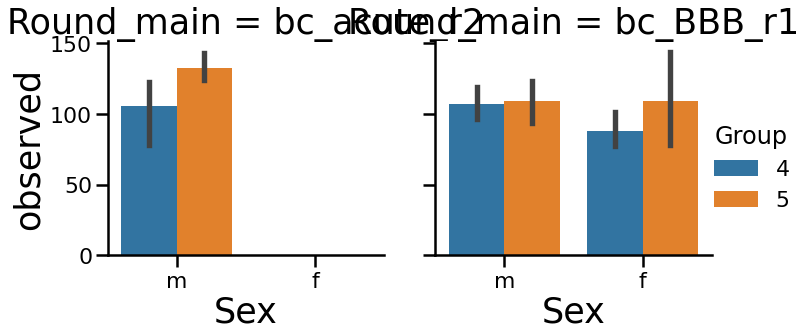





shannon


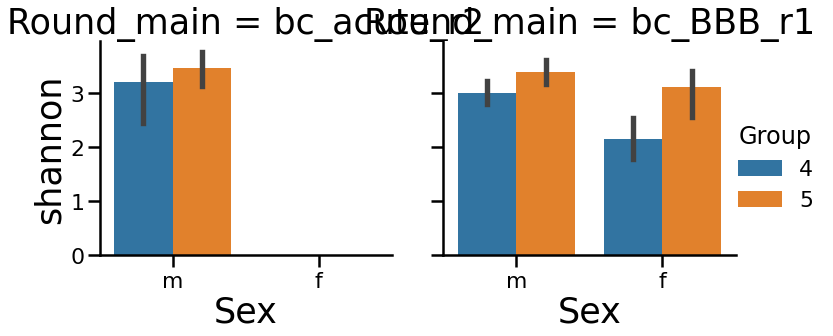





chao1


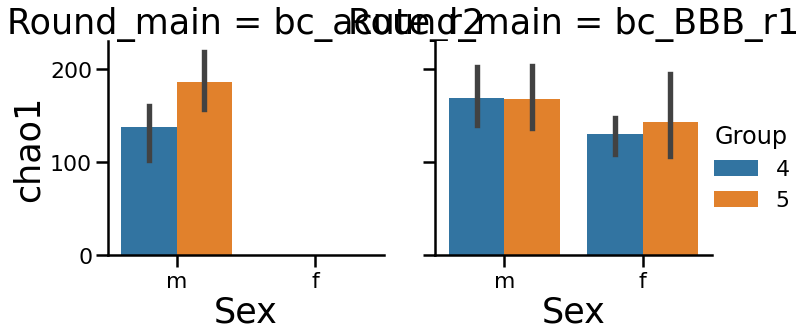

In [8]:
data_tp = data_alpha_final[data_alpha_final['feces_tp'] == 1]

#viz abundance params and compute significance
viz_params = ['observed', 'shannon', 'chao1']

for param in viz_params:
    try:
        print(param)

        g = sns.catplot(x='Sex', y=param, data=data_tp, kind='bar', height=5, aspect=1, hue='Group', col='Round_main')
        plt.show()
        print('\n')
        
        #x = OTU_data_diversity[OTU_data_diversity['group'] == 4][param]
        #y = OTU_data_diversity[OTU_data_diversity['group'] == 5][param]
        #z = OTU_data_diversity[OTU_data_diversity['group'] == 7][param]
        #print(stats.kruskal(y, z))
        print('\n')
        
    except:
        pass

### beta diversity

#### compile animal meta and filtered otu table 

In [9]:
#use file name to create path of files
data_otu = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'otu')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@otu').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_otu.shape[0] == 0:
        data_otu = data_int
    else:
        data_otu = pd.concat([data_otu, data_int])
    
    print(data_otu.shape)

#data_otu.replace({np.nan: 0}, inplace=True)    
print(data_otu.shape)
data_otu.tail()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/filtered-tables/otutable-filtered-relative.tsv
(35, 364)
(35, 364)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/filtered-tables/otutable-filtered-relative.tsv
(58, 371)
(93, 400)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/filtered-tables/otutable-filtered-relative.tsv
(49, 413)
(142, 464)
(142, 464)


,animal_code,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_001454945.1,GCF_001487165.1,GCF_001486905.1,GCF_001535605.1,GCF_001517625.2,GCF_001535615.1,GCF_001688765.2,GCF_001688705.2,GCF_001578565.1,GCF_001546525.1,GCF_001688665.2,GCF_001578575.1,GCF_001641065.1,GCF_001688625.2,GCF_001688645.2,GCF_001688725.2,GCF

In [10]:
#combine with meta data
data_otu_final = data_animal_meta.merge(data_otu, 
                                          on=['animal_code', 'file_name'])

print(data_otu_final.shape)
data_otu_final.head()

(101, 510)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_0014066

In [25]:
sb_groups = [4,5]

data_all = data_otu_final[data_otu_final['feces_tp'] == 1]
data_all = data_all[data_all['Round_main'] == 'bc_BBB_r1']
data_all_sbm = data_all[data_all['Sex'] == 'm']
data_all_sbf = data_all[data_all['Sex'] == 'f']

In [26]:
data_all.dropna(axis=1, inplace=True)
data_all.columns.values

array(['Protocol', 'Round_summary', 'Round_main', 'file_name', 'Animal_#',
       'animal_code', 'Cage_#', 'Group', 'Sex', 'feces_tp', 'feces_fs',
       'Acute_OFB', 'Sac_TP', 'Treatment', 'wt_1', 'wt_2', 'wt_3',
       'wt_48', 'wt_overnight', 'wt_48.1', 'Distance', 'Mean speed',
       'Center : entries', 'Center : time', 'Center : distance',
       'Center : latency', 'GCF_001945605.1', 'GCF_000008065.1',
       'GCF_000007785.1', 'GCF_001055755.1', 'GCF_000205025.1',
       'GCF_000144975.1', 'GCF_000020225.1', 'GCF_000009925.1',
       'GCF_000011065.1', 'GCF_000012825.1', 'GCF_000014425.1',
       'GCF_000020605.1', 'GCF_000091405.1', 'GCF_000162275.1',
       'GCF_000159355.1', 'GCF_000157075.2', 'GCF_000153885.1',
       'GCF_000156195.1', 'GCF_000154425.1', 'GCF_000154385.1',
       'GCF_000154285.1', 'GCF_000156035.2', 'GCF_000154565.1',
       'GCF_000154465.1', 'GCF_000154505.1', 'GCF_000154825.1',
       'GCF_000156015.1', 'GCF_000156535.1', 'GCF_000156495.1',
       'GCF

In [27]:
otus = ['GCF_001945605.1', 'GCF_000008065.1',
       'GCF_000007785.1', 'GCF_001055755.1', 'GCF_000205025.1',
       'GCF_000144975.1', 'GCF_000020225.1', 'GCF_000009925.1',
       'GCF_000011065.1', 'GCF_000012825.1', 'GCF_000014425.1',
       'GCF_000020605.1', 'GCF_000091405.1', 'GCF_000162275.1',
       'GCF_000159355.1', 'GCF_000157075.2', 'GCF_000153885.1',
       'GCF_000156195.1', 'GCF_000154425.1', 'GCF_000154385.1',
       'GCF_000154285.1', 'GCF_000156035.2', 'GCF_000154565.1',
       'GCF_000154465.1', 'GCF_000154505.1', 'GCF_000154825.1',
       'GCF_000156015.1', 'GCF_000156535.1', 'GCF_000156495.1',
       'GCF_000157055.1', 'GCF_000157035.2', 'GCF_000158655.1',
       'GCF_000158075.1', 'GCF_000157995.1', 'GCF_000157975.1',
       'GCF_000157955.1', 'GCF_000159055.1', 'GCF_000162135.1',
       'GCF_000160095.1', 'GCF_000162015.1', 'GCF_000162195.1',
       'GCF_000178255.1', 'GCF_000163675.1', 'GCF_000162555.1',
       'GCF_000174195.1', 'GCF_000169255.2', 'GCF_000177035.2',
       'GCF_000204985.1', 'GCF_000189615.1', 'GCF_000189595.1',
       'GCF_000186525.1', 'GCF_000190355.1', 'GCF_000364245.1',
       'GCF_000307345.1', 'GCF_000273215.1', 'GCF_000233515.1',
       'GCF_000225745.1', 'GCF_000205165.1', 'GCF_000210575.1',
       'GCF_000225345.1', 'GCF_000225685.1', 'GCF_000239295.1',
       'GCF_000235445.1', 'GCF_000234155.1', 'GCF_000235505.1',
       'GCF_000238635.1', 'GCF_000242175.1', 'GCF_000242955.1',
       'GCF_000265365.1', 'GCF_000260715.1', 'GCF_000273075.1',
       'GCF_000273195.1', 'GCF_000273315.1', 'GCF_000273725.1',
       'GCF_000281195.1', 'GCF_000364225.1', 'GCF_000364185.1',
       'GCF_000364165.1', 'GCF_000312145.1', 'GCF_000307395.1',
       'GCF_000311925.1', 'GCF_000320405.1', 'GCF_000317915.1',
       'GCF_000403195.1', 'GCF_000403175.1', 'GCF_000374505.1',
       'GCF_000371525.1', 'GCF_000371485.1', 'GCF_000371425.1',
       'GCF_000371505.1', 'GCF_000371545.1', 'GCF_000403155.2',
       'GCF_000498675.1', 'GCF_000403415.2', 'GCF_000403235.1',
       'GCF_000403395.2', 'GCF_000403355.2', 'GCF_000403435.2',
       'GCF_000403455.2', 'GCF_000422625.1', 'GCF_000403845.2',
       'GCF_000403825.2', 'GCF_000411355.1', 'GCF_000411335.1',
       'GCF_000413395.1', 'GCF_000478885.1', 'GCF_000471945.1',
       'GCF_000466445.2', 'GCF_000424325.1', 'GCF_000424225.1',
       'GCF_000427365.1', 'GCF_000424345.1', 'GCF_000439275.1',
       'GCF_000469345.1', 'GCF_000466485.1', 'GCF_000492175.1',
       'GCF_000484655.1', 'GCF_000800475.2', 'GCF_000741575.1',
       'GCF_000709415.1', 'GCF_000526735.1', 'GCF_000507805.1',
       'GCF_000507785.1', 'GCF_000512915.1', 'GCF_000702025.1',
       'GCF_000701665.1', 'GCF_000723745.2', 'GCF_000741135.1',
       'GCF_000742975.1', 'GCF_000765135.1', 'GCF_000760655.1',
       'GCF_000765245.1', 'GCF_000821285.2', 'GCF_000953575.1',
       'GCF_001816245.2', 'GCF_001543345.1', 'GCF_001405255.1',
       'GCF_001405095.1', 'GCF_001314975.1', 'GCF_001244545.1',
       'GCF_001063505.1', 'GCF_001078435.1', 'GCF_001073155.1',
       'GCF_001244495.1', 'GCF_001185345.1', 'GCF_001280875.1',
       'GCF_001244995.1', 'GCF_001281305.1', 'GCF_001312505.1',
       'GCF_001311035.1', 'GCF_001404335.1', 'GCF_001318345.1',
       'GCF_001404555.1', 'GCF_001404375.1', 'GCF_001404495.1',
       'GCF_001404475.1', 'GCF_001404435.1', 'GCF_001405075.1',
       'GCF_001404755.1', 'GCF_001404635.1', 'GCF_001404595.1',
       'GCF_001404735.1', 'GCF_001405015.1', 'GCF_001404815.1',
       'GCF_001405115.1', 'GCF_001405155.1', 'GCF_001405175.1',
       'GCF_001405215.1', 'GCF_001405235.1', 'GCF_001406535.1',
       'GCF_001405895.1', 'GCF_001405595.1', 'GCF_001405335.1',
       'GCF_001405315.1', 'GCF_001405515.1', 'GCF_001405415.1',
       'GCF_001405555.1', 'GCF_001405535.1', 'GCF_001405675.1',
       'GCF_001405615.1', 'GCF_001405655.1', 'GCF_001405855.1',
       'GCF_001406335.1', 'GCF_001406075.1', 'GCF_001406015.1',
       'GCF_001405975.1', 'GCF_001405955.1', 'GCF_001405995.1',
       'GCF_001406055.1', 'GCF_001406175.1', 'GCF_001406435.1',
       'GCF_001406395.1', 'GCF_001406375.1', 'GCF_001406675.1',
       'GCF_001406635.1', 'GCF_001406615.1', 'GCF_001406595.1',
       'GCF_001406755.1', 'GCF_001406695.1', 'GCF_001406715.1',
       'GCF_001435325.1', 'GCF_001434435.1', 'GCF_001486665.1',
       'GCF_001436695.1', 'GCF_001436575.1', 'GCF_001436315.1',
       'GCF_001461035.1', 'GCF_001454945.1', 'GCF_001487165.1',
       'GCF_001486905.1', 'GCF_001517625.2', 'GCF_001535615.1',
       'GCF_001688765.2', 'GCF_001688705.2', 'GCF_001578565.1',
       'GCF_001546525.1', 'GCF_001688665.2', 'GCF_001578575.1',
       'GCF_001641065.1', 'GCF_001688625.2', 'GCF_001688645.2',
       'GCF_001688725.2', 'GCF_001811315.1', 'GCF_001714745.1',
       'GCF_001688845.2', 'GCF_001806555.1', 'GCF_001754075.1',
       'GCF_001717135.1', 'GCF_001811695.1', 'GCF_001813275.1',
       'GCF_001945525.1', 'GCF_900106755.1', 'GCF_002885415.1',
       'GCF_002885375.1', 'GCF_002282915.1', 'GCF_002253185.1',
       'GCF_002176855.1', 'GCF_002007185.1', 'GCF_002003555.1',
       'GCF_002160535.1', 'GCF_002176835.1', 'GCF_002201515.1',
       'GCF_002201495.1', 'GCF_002201475.1', 'GCF_002180435.1',
       'GCF_002253105.1', 'GCF_002253165.1', 'GCF_002253145.1',
       'GCF_002253465.1', 'GCF_002253325.1', 'GCF_002253245.1',
       'GCF_002253205.1', 'GCF_002253195.1', 'GCF_002253275.1',
       'GCF_002253265.1', 'GCF_002253285.1', 'GCF_002253385.1',
       'GCF_002253445.1', 'GCF_002269975.1', 'GCF_002706665.1',
       'GCF_002549855.1', 'GCF_002549755.1', 'GCF_002549775.1',
       'GCF_002549945.1', 'GCF_002549935.1', 'GCF_002549905.1',
       'GCF_002885335.1', 'GCF_002885315.1', 'GCF_002803405.1',
       'GCF_002761235.1', 'GCF_002885215.1', 'GCF_002885155.1',
       'GCF_002865325.1', 'GCF_002865285.1', 'GCF_002863445.1',
       'GCF_002865345.1', 'GCF_002885015.1', 'GCF_002884915.1',
       'GCF_002885295.1', 'GCF_002885255.1', 'GCF_002885475.1',
       'GCF_002885425.1', 'GCF_002885465.1', 'GCF_900104675.1',
       'GCF_900083545.1', 'GCF_002915525.1', 'GCF_900021155.1',
       'GCF_900016875.1', 'GCF_900086585.1', 'GCF_900086725.1',
       'GCF_900100465.1', 'GCF_900102365.1', 'GCF_900104645.1',
       'GCF_900108155.1', 'GCF_900106845.1', 'GCF_900107825.1',
       'GCF_900107675.1', 'GCF_900109965.1', 'GCF_900109385.1',
       'GCF_900109635.1', 'GCF_900155865.1', 'GCF_900113155.1',
       'GCF_900112995.1', 'GCF_900129135.1', 'GCF_900114865.1',
       'GCF_900114575.1', 'GCF_900120155.1', 'GCF_900120345.1',
       'GCF_900120195.1', 'GCF_900120295.1', 'GCF_900142265.1',
       'GCF_900142165.1', 'GCF_900142955.1', 'GCF_900155395.1',
       'GCF_900148495.1', 'GCF_900209925.1', 'GCF_900169665.1',
       'GCF_900169495.1', 'GCF_900169975.1', 'GCF_900199515.1',
       'GCF_900199495.1', 'GCF_900243045.1', 'GCF_900290115.1',
       'GCF_900312975.1', 'GCF_000012405.1', 'GCF_000021425.1',
       'GCF_000155205.1', 'GCF_000185625.1', 'GCF_000210055.1',
       'GCF_000227705.2', 'GCF_000233655.1', 'GCF_000286395.1',
       'GCF_000379665.1', 'GCF_000382465.1', 'GCF_000424085.1',
       'GCF_000424445.1', 'GCF_000497205.1', 'GCF_001042635.1',
       'GCF_001404355.1', 'GCF_001405835.1', 'GCF_001487105.1',
       'GCF_002148255.1', 'GCF_002253365.1', 'GCF_900101315.1',
       'GCF_900095865.1', 'GCF_900102595.1', 'GCF_900155735.1',
       'GCF_000152245.2', 'GCF_000154065.1', 'GCF_000158555.2',
       'GCF_000173815.1', 'GCF_000172575.2', 'GCF_000183825.1',
       'GCF_000190575.1', 'GCF_000210755.1', 'GCF_000236865.1',
       'GCF_000242675.1', 'GCF_000270285.1', 'GCF_000308295.2',
       'GCF_000364205.1', 'GCF_000380265.1', 'GCF_000403375.2',
       'GCF_000466465.2', 'GCF_000425525.1', 'GCF_000499525.1',
       'GCF_000577895.1', 'GCF_000685785.1', 'GCF_000719975.1',
       'GCF_000753455.2', 'GCF_000807675.2', 'GCF_000814825.1',
       'GCF_000820725.1', 'GCF_001083815.1', 'GCF_001434405.1',
       'GCF_001434535.1', 'GCF_001436015.1', 'GCF_001438695.1',
       'GCF_001517665.2', 'GCF_001552975.1', 'GCF_001564455.1',
       'GCF_001806625.1', 'GCF_001806735.1', 'GCF_001811595.1',
       'GCF_001886675.1', 'GCF_001878735.1', 'GCF_001931845.1',
       'GCF_001953785.1', 'GCF_001989555.1', 'GCF_002025645.1',
       'GCF_002140075.1', 'GCF_002155915.1', 'GCF_002163735.1',
       'GCF_002208945.1', 'GCF_002232035.1', 'GCF_002310475.1',
       'GCF_002355755.1', 'GCF_002836835.1', 'GCF_002814115.1',
       'GCF_002884995.1', 'GCF_002885105.1', 'GCF_002894975.1',
       'GCF_900103615.1', 'GCF_900116145.1', 'GCF_900155435.1',
       'GCF_900155615.1', 'GCF_900170005.1', 'GCF_900169505.1',
       'GCF_900183385.1', 'GCF_900199375.1', 'GCF_900199545.1',
       'GCF_900199705.1']



data_otu_final.head()

,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_0014066

### compute beta

In [28]:
data_touse = data_all

ids = data_touse['animal_code'].values
#compute beta diversity dissimilary 
bc_dm = beta_diversity("braycurtis", data_touse[otus].to_numpy(), ids)

print(bc_dm[0])

[0.         0.27841107 0.14503774 0.06129576 0.24124354 0.12289951
 0.69598228 0.5773006  0.47087691 0.49207996 0.37518165 0.44364072
 0.44684945 0.27362353 0.39264594 0.82359506 0.73253431 0.73266368
 0.39975748 0.70513169 0.64050416]


In [47]:
from skbio.stats.ordination import pcoa

pcoa_results = pcoa(bc_dm)
pc_df = skbio.stats.ordination.pcoa(bc_dm).samples
pc_df['animal_code'] = pc_df.index
data_beta_final = data_touse.merge(pc_df, on='animal_code')
data_beta_final.head()

,Protocol,Round_summary,Round_main,file_name,Animal_#,animal_code,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,wt_1,wt_2,wt_3,wt_48,wt_overnight,wt_48.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000162555.1,GCF_000174195.1,GCF_000169255.2,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273725.1,GCF_000281195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_001454945.1,GCF_001487165.1,GCF_001486905.1,GCF_001517625.2,GCF_001535615.1,GCF_001688765.2,GCF_001688705.2,GCF_001578565.1,GCF_001546525.1,GCF_001688665.2,GCF_001578575.1,GCF_001641065.1,GCF_001688625.2,GCF_001688645.2,GCF_001688725.2,GCF_001811315.1,GCF_001714745.1,GCF_001688845.2,GCF_001806555.1,GCF_001754075.1,GCF_001717135.1,GCF_001811695.1,GCF_001813275.1,GCF_001945525.1,GCF_900106755.1,GCF_002885415.1,GCF_002885375.1,

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

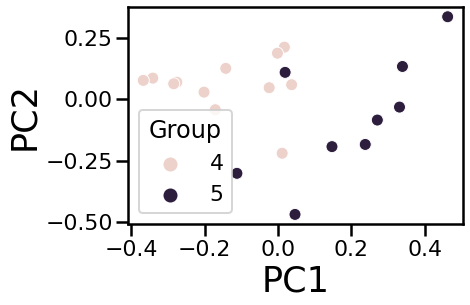

In [49]:
sns.scatterplot(data=data_beta_final, x="PC1", y="PC2", hue='Group')

In [ ]:
sample_md = data_touse[['animal_code', 'Group']].set_index(['animal_code'])

#determine if sig
anosim_stat = anosim(bc_dm, sample_md, column='Group', permutations=500)
print(anosim_stat, '\n')
permanova_stat = permanova(bc_dm, sample_md, column='Group', permutations=500)
print(permanova_stat)

## Taxa level analysis and viz

#### phylum

In [ ]:
#use file name to create path of files
data_phylum = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'phylum')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@tax_phylum_level').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_phylum.shape[0] == 0:
        data_phylum = data_int
    else:
        data_phylum = pd.concat([data_phylum, data_int])
    
    print(data_phylum.shape)

data_phylum.replace({np.nan: 0}, inplace=True)    
print(data_phylum.shape)
data_phylum.tail()


In [ ]:
#combine with meta data
data_phylum_final = data_animal_meta.merge(data_phylum, 
                                          on=['animal_code', 'file_name'])

print(data_phylum_final.shape)
data_phylum_final.head()

In [ ]:
#calculate ratios etc.
data_phylum_final['fb_ratio'] = data_phylum_final['p__Firmicutes'] / data_phylum_final['p__Bacteroidetes']
data_phylum_final['va_sum'] = data_phylum_final['p__Verrucomicrobia'] + data_phylum_final['p__Actinobacteria']

In [ ]:
data_tp = data_phylum_final[data_phylum_final['Round_summary'] == 'norBNI']

In [ ]:
#determine potential significance 
params = ['p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Fusobacteria', 'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia', 
          'fb_ratio', 'va_sum']

for param in params:
    try:
        print(param)

        g = sns.catplot(x='Group', y=param, data=data_tp, kind='bar', height=5, aspect=4)
        plt.show()
        print('\n')
        
        #x = OTU_data_diversity[OTU_data_diversity['group'] == 4][param]
        #y = OTU_data_diversity[OTU_data_diversity['group'] == 5][param]
        #z = OTU_data_diversity[OTU_data_diversity['group'] == 7][param]
        #print(stats.kruskal(y, z))
        print('\n')
        
    except:
        pass

In [ ]:
data_tp.columns.values

In [ ]:
data_tp[['Group', 'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Fusobacteria', 'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia']].groupby('Group').mean().plot(kind='bar', stacked=True, figsize=(10,5))
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [ ]:
corr = data_24.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr)

In [ ]:
data_final.to_csv('data_final.csv')